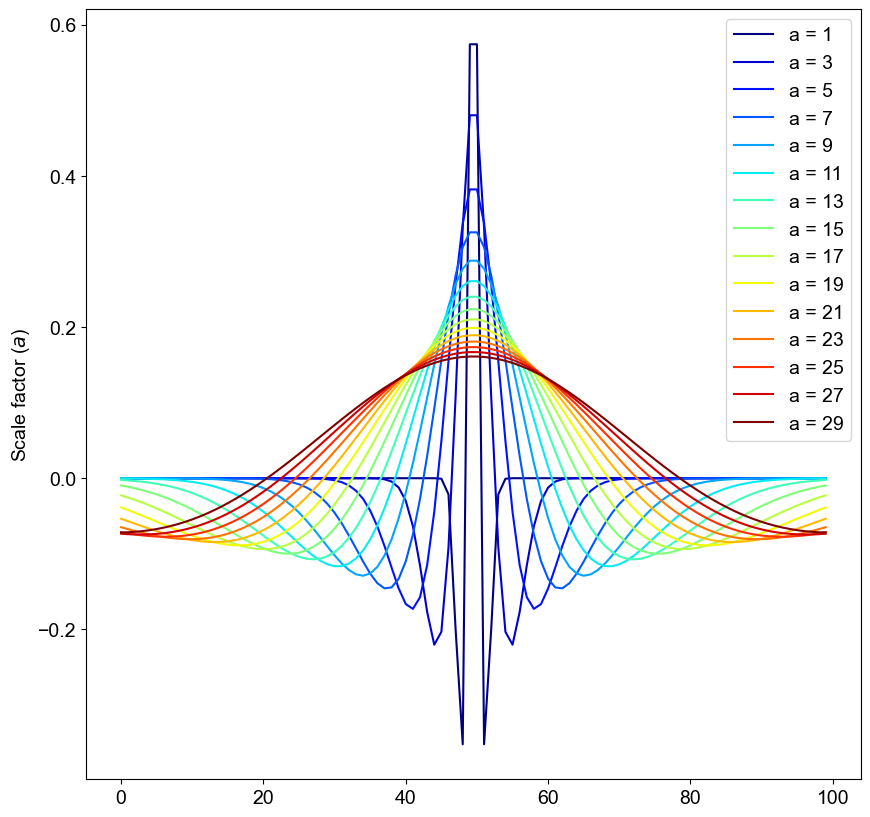

In [1]:
from scipy import signal
import numpy as np
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
colors = pl.cm.jet(np.linspace(0, 1, 15))

self.fig = plt.figure(figsize=[10, 10])
self.ax = self.fig.add_subplot()

points = 100
for i, a in enumerate(np.arange(1, 30, 2)):
    vec2 = signal.ricker(points, a)
    self.ax.plot(vec2, label='a = '+str(a), c=colors[i])

self.ax.set_ylabel('Scale factor ($a$)')
plt.legend()
plt.show()

(5444, 500)
(5444, 500)
(5444, 500)


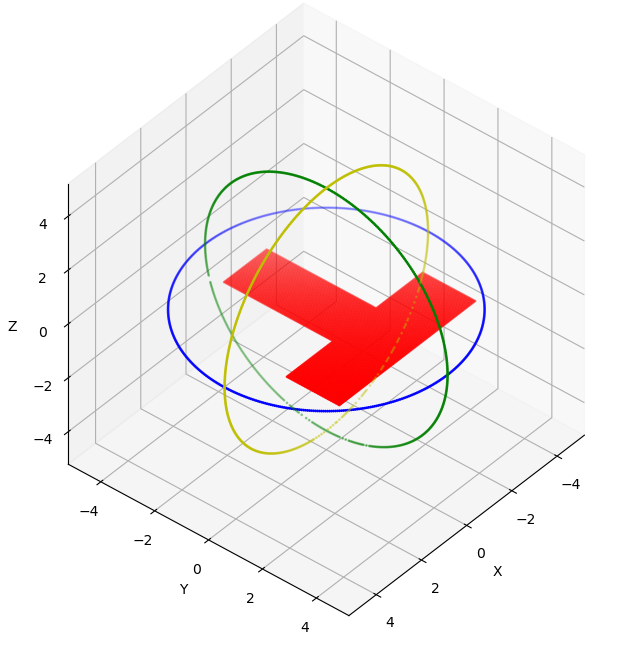

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def compute_angle(A, B):
    """
    Compute the angles between vectors A and B.
    
    Parameters:
    - A: A 2D array where each row is a vector from the T-shape.
    - B: A 2D array where each row is a vector from a reference circle.
    
    Returns:
    - angles: A 2D array where each element (i, j) is the angle between vector A[i] and vector B[j].
    """
    dot_product = np.einsum('ij,kj->ik', A, B)
    mod_A = np.linalg.norm(A, axis=1)[:, np.newaxis]
    mod_B = np.linalg.norm(B, axis=1)
    
    cos_theta = dot_product / (mod_A * mod_B)
    cos_theta = np.clip(cos_theta, -1, 1) # Clip values to handle potential numerical errors
    angles = np.arccos(cos_theta)
    
    return angles

class TShapePlotter:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')

    azim = 30
    elev = 20

    def __init__(self, vertical_length, horizontal_length, width):
        self.vertical_length = vertical_length
        self.horizontal_length = horizontal_length
        self.width = width

    def _generate_t_shape(self):
        # Calculate square and corner sizes
        self.frame_width = self.horizontal_length
        self.frame_height = self.vertical_length + self.width
        
        x, y = np.meshgrid(np.linspace(-self.frame_width/2, self.frame_width/2, 100), 
                           np.linspace(-self.frame_height/2, self.frame_height/2, 100))
        
        # Masks for removing bottom corners
        mask_left = np.logical_or(x > -self.width/2, y > self.frame_height/2 - self.width)
        mask_right = np.logical_or(x < self.width/2, y > self.frame_height/2 - self.width)
        mask = np.logical_and(mask_left, mask_right)
        
        self.x = x[mask]
        self.y = y[mask]
        self.z = np.zeros_like(self.x)

    def _generate_ref_circles(self, diameter, n_ref_points):
        theta = np.linspace(0, 2*np.pi, n_ref_points)

        # Circle parallel to XY plane
        self.x_xy = diameter/2 * np.cos(theta)
        self.y_xy = diameter/2 * np.sin(theta)
        self.z_xy = np.zeros_like(theta)
        
        # Circle parallel to YZ plane
        self.x_yz = np.zeros_like(theta)
        self.y_yz = diameter/2 * np.cos(theta)
        self.z_yz = diameter/2 * np.sin(theta)
        
        # Circle parallel to XZ plane
        self.x_xz = diameter/2 * np.cos(theta)
        self.y_xz = np.zeros_like(theta)
        self.z_xz = diameter/2 * np.sin(theta)

    def _rotate(self, x, y, z, euler_angles):
        rotation = R.from_euler('ZYX', euler_angles, degrees=True)
        rotated_points = rotation.apply(np.column_stack([x, y, z]))

        return rotated_points[:, 0], rotated_points[:, 1], rotated_points[:, 2]

    def _from_camera(self, x, y, z, ax):
        azim_rad = np.deg2rad(ax.azim)
        elev_rad = np.deg2rad(ax.elev)

        # Calculate the camera's absolute coordinates
        camera_x = ax._dist * np.cos(elev_rad) * np.cos(azim_rad)
        camera_y = ax._dist * np.cos(elev_rad) * np.sin(azim_rad)
        camera_z = ax._dist * np.sin(elev_rad)

        # Compute the vectors from the camera to each point on the T-shape
        vectors_x = x - camera_x
        vectors_y = y - camera_y
        vectors_z = z - camera_z

        return vectors_x, vectors_y, vectors_z

    def _mask_occlusion(self, circle_vectors, t_shape_vectors, angle_threshold):
        """
        Create a mask for the reference circle points based on angles with T-shape points and moduli.
        
        Parameters:
        - circle_vectors: A 2D array where each row is a vector from a reference circle.
        - t_shape_vectors: A 2D array where each row is a vector from the T-shape.
        - angle_threshold: The angle threshold for determining occlusion.
        
        Returns:
        - mask: A boolean array indicating which points on the reference circle to keep.
        """
        angles = compute_angle(t_shape_vectors, circle_vectors)
        min_angles = np.min(angles, axis=0)
        
        mod_circle = np.linalg.norm(circle_vectors, axis=1)
        mod_t_shape = np.linalg.norm(t_shape_vectors, axis=1)
        
        # Check angle threshold and moduli to determine the mask
        mask_angle = min_angles > angle_threshold
        mask_modulus = np.all(mod_circle[:, np.newaxis] > mod_t_shape, axis=1)
        
        mask = np.logical_or(mask_angle, np.logical_not(mask_modulus))
        
        return mask

    def draw(self, euler_angles=[0, 0, 0], ref_diameter=1.5, n_ref_points=200, angle_threshold_deg=5):
        self._generate_t_shape()
        self._generate_ref_circles(ref_diameter*max(self.frame_height, self.frame_width),
                                   n_ref_points)
        
        x_rot, y_rot, z_rot = self._rotate(self.x, self.y, self.z, euler_angles)
        x_xy_rot, y_xy_rot, z_xy_rot = self._rotate(self.x_xy, self.y_xy, self.z_xy, euler_angles)
        x_yz_rot, y_yz_rot, z_yz_rot = self._rotate(self.x_yz, self.y_yz, self.z_yz, euler_angles)
        x_xz_rot, y_xz_rot, z_xz_rot = self._rotate(self.x_xz, self.y_xz, self.z_xz, euler_angles)

        # Plot the T-shape in 3D

        self.ax.view_init(elev=self.elev, azim=self.azim)
        self.ax.set_proj_type('ortho')

        # Compute vectors from the camera for each object
        vectors_t_x, vectors_t_y, vectors_t_z = self._from_camera(x_rot, y_rot, z_rot, self.ax)
        vectors_xy_x, vectors_xy_y, vectors_xy_z = self._from_camera(x_xy_rot, y_xy_rot, z_xy_rot, self.ax)
        vectors_yz_x, vectors_yz_y, vectors_yz_z = self._from_camera(x_yz_rot, y_yz_rot, z_yz_rot, self.ax)
        vectors_xz_x, vectors_xz_y, vectors_xz_z = self._from_camera(x_xz_rot, y_xz_rot, z_xz_rot, self.ax)
        
        # Compute masks for each reference circle
        mask_xy = self._mask_occlusion(np.column_stack([vectors_xy_x, vectors_xy_y, vectors_xy_z]), 
                                       np.column_stack([vectors_t_x, vectors_t_y, vectors_t_z]), 
                                       np.deg2rad(angle_threshold_deg))
        mask_yz = self._mask_occlusion(np.column_stack([vectors_yz_x, vectors_yz_y, vectors_yz_z]), 
                                       np.column_stack([vectors_t_x, vectors_t_y, vectors_t_z]), 
                                       np.deg2rad(angle_threshold_deg))
        mask_xz = self._mask_occlusion(np.column_stack([vectors_xz_x, vectors_xz_y, vectors_xz_z]), 
                                       np.column_stack([vectors_t_x, vectors_t_y, vectors_t_z]), 
                                       np.deg2rad(angle_threshold_deg))

        self.ax.scatter(x_rot, y_rot, z_rot, c='r', s=1)
        # Use masks to plot only the visible points on the reference circles
        self.ax.scatter(x_xy_rot[mask_xy], y_xy_rot[mask_xy], z_xy_rot[mask_xy], c='b', s=1, label='XY Circle')
        self.ax.scatter(x_yz_rot[mask_yz], y_yz_rot[mask_yz], z_yz_rot[mask_yz], c='g', s=1, label='YZ Circle')
        self.ax.scatter(x_xz_rot[mask_xz], y_xz_rot[mask_xz], z_xz_rot[mask_xz], c='y', s=1, label='XZ Circle')
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')

        self.ax.set_xlim([-5, 5])
        self.ax.set_ylim([-5, 5])
        self.ax.set_zlim([-5, 5])

        self.ax.set_box_aspect((1, 1, 1))
        plt.show()


plotter = TShapePlotter(4, 6, 2)
plotter.azim = 40
plotter.elev = 40

plotter.draw([0, 0, 0], n_ref_points=500, angle_threshold_deg=0.1)

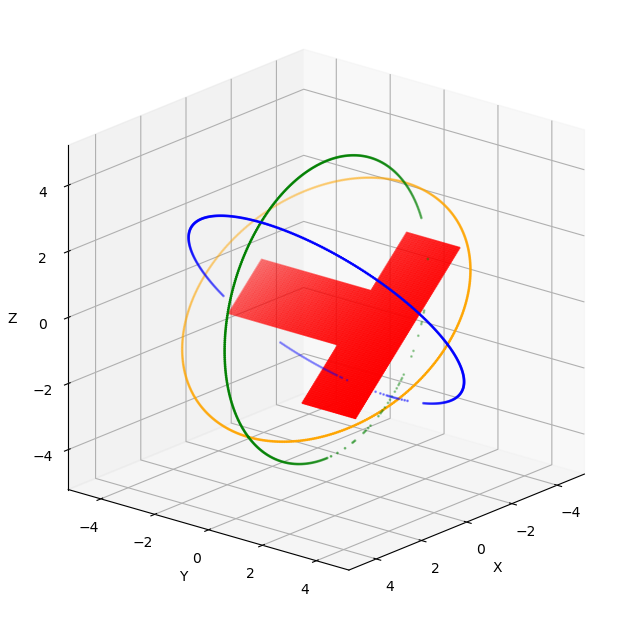

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def compute_angle(A, B):
    """
    Compute the angles between vectors A and B.
    
    Parameters:
    - A: A 2D array where each row is a vector from the T-shape.
    - B: A 2D array where each row is a vector from a reference circle.
    
    Returns:
    - angles: A 2D array where each element (i, j) is the angle between vector A[i] and vector B[j].
    """
    dot_product = np.einsum('ij,kj->ik', A, B)
    mod_A = np.linalg.norm(A, axis=1)[:, np.newaxis]
    mod_B = np.linalg.norm(B, axis=1)
    
    cos_theta = dot_product / (mod_A * mod_B)
    cos_theta = np.clip(cos_theta, -1, 1) # Clip values to handle potential numerical errors
    angles = np.arccos(cos_theta)
    
    return angles

class TShapePlotter:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')

    azim = 30
    elev = 20

    def __init__(self, vertical_length, horizontal_length, width):
        self.vertical_length = vertical_length
        self.horizontal_length = horizontal_length
        self.width = width

    def _generate_t(self):
        # Calculate square and corner sizes
        self.frame_width = self.horizontal_length
        self.frame_height = self.vertical_length + self.width
        
        x, y = np.meshgrid(np.linspace(-self.frame_width/2, self.frame_width/2, 100), 
                           np.linspace(-self.frame_height/2, self.frame_height/2, 100))
        
        # Masks for removing bottom corners
        mask_left = np.logical_or(x > -self.width/2, y > self.frame_height/2 - self.width)
        mask_right = np.logical_or(x < self.width/2, y > self.frame_height/2 - self.width)
        mask = np.logical_and(mask_left, mask_right)
        
        self.t_shape = np.column_stack([x[mask], y[mask], np.zeros_like(x[mask])])

    def _generate_ref_circ(self, diameter, n_ref_points):
        theta = np.linspace(0, 2*np.pi, n_ref_points)

        # Circle parallel to XY plane
        x_xy = diameter/2 * np.cos(theta)
        y_xy = diameter/2 * np.sin(theta)
        z_xy = np.zeros_like(theta)
        
        # Circle parallel to YZ plane
        x_yz = np.zeros_like(theta)
        y_yz = diameter/2 * np.cos(theta)
        z_yz = diameter/2 * np.sin(theta)
        
        # Circle parallel to ZX plane
        x_zx = diameter/2 * np.cos(theta)
        y_zx = np.zeros_like(theta)
        z_zx = diameter/2 * np.sin(theta)

        self.xy_circle = np.column_stack([x_xy, y_xy, z_xy])
        self.yz_circle = np.column_stack([x_yz, y_yz, z_yz])
        self.zx_circle = np.column_stack([x_zx, y_zx, z_zx])

    def _rotate(self, coords, euler_angles):
        rotation = R.from_euler('ZYX', euler_angles, degrees=True)
        return rotation.apply(coords)

    def _from_camera(self, coords):
        azim_rad = np.deg2rad(self.ax.azim)
        elev_rad = np.deg2rad(self.ax.elev)

        # Calculate the camera's absolute coordinates
        camera_coords = self.ax._dist * np.array([
            np.cos(elev_rad) * np.cos(azim_rad),
            np.cos(elev_rad) * np.sin(azim_rad),
            np.sin(elev_rad)
        ])

        # Compute the vectors from the camera to each point on the object
        return coords - camera_coords

    def _mask_occlusion(self, circle_vectors, t_shape_vectors, angle_threshold):
        """
        Create a mask for the reference circle points based on angles with T-shape points and moduli.
        
        Parameters:
        - circle_vectors: A 2D array where each row is a vector from a reference circle.
        - t_shape_vectors: A 2D array where each row is a vector from the T-shape.
        - angle_threshold: The angle threshold for determining occlusion.
        
        Returns:
        - mask: A boolean array indicating which points on the reference circle to keep.
        """
        angles = compute_angle(t_shape_vectors, circle_vectors)
        min_angles = np.min(angles, axis=0)
        
        mod_circle = np.linalg.norm(circle_vectors, axis=1)
        mod_t_shape = np.linalg.norm(t_shape_vectors, axis=1)
        
        # Check angle threshold and moduli to determine the mask
        mask_angle = min_angles > angle_threshold
        # print(mask_angle.shape)
        mask_modulus = np.all(mod_circle[:, np.newaxis] > mod_t_shape, axis=1)
        
        mask = np.logical_or(mask_angle, np.logical_not(mask_modulus))
        
        return mask

    def draw(self, euler_angles=[0, 0, 0], ref_diameter=1.5, n_ref_points=200, angle_threshold_deg=5):
        self._generate_t()
        self._generate_ref_circ(ref_diameter*max(self.frame_height, self.frame_width),
                                   n_ref_points)
        
        t_rot = self._rotate(self.t_shape, euler_angles)
        xy_rot = self._rotate(self.xy_circle, euler_angles)
        yz_rot = self._rotate(self.yz_circle, euler_angles)
        zx_rot = self._rotate(self.zx_circle, euler_angles)

        # Plot the T-shape in 3D
        self.ax.view_init(elev=self.elev, azim=self.azim)
        self.ax.set_proj_type('ortho')

        # Compute vectors from the camera for each object
        vec_t_cam = self._from_camera(t_rot)
        vec_xy_cam = self._from_camera(xy_rot)
        vec_yz_cam = self._from_camera(yz_rot)
        vec_zx_cam = self._from_camera(zx_rot)

        # Compute masks for each reference circle
        mask_xy = self._mask_occlusion(vec_xy_cam, vec_t_cam, np.deg2rad(angle_threshold_deg))
        mask_yz = self._mask_occlusion(vec_yz_cam, vec_t_cam, np.deg2rad(angle_threshold_deg))
        mask_zx = self._mask_occlusion(vec_zx_cam, vec_t_cam, np.deg2rad(angle_threshold_deg))

        self.ax.scatter(t_rot[:, 0], t_rot[:, 1], t_rot[:, 2],
                        c='r', s=1)
        # Use masks to plot only the visible points on the reference circles
        self.ax.scatter(xy_rot[mask_xy][:, 0], xy_rot[mask_xy][:, 1], xy_rot[mask_xy][:, 2],
                        c='orange', s=1, label='XY Circle')
        self.ax.scatter(yz_rot[mask_yz][:, 0], yz_rot[mask_yz][:, 1], yz_rot[mask_yz][:, 2],
                        c='blue', s=1, label='YZ Circle')
        self.ax.scatter(zx_rot[mask_zx][:, 0], zx_rot[mask_zx][:, 1], zx_rot[mask_zx][:, 2],
                        c='green', s=1, label='ZX Circle')
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')

        self.ax.set_xlim([-5, 5])
        self.ax.set_ylim([-5, 5])
        self.ax.set_zlim([-5, 5])

        self.ax.set_box_aspect((1, 1, 1))
        # plt.show()


plotter = TShapePlotter(4, 6, 2)
plotter.azim = 40
plotter.elev = 20

plotter.draw([0, 40, 0], n_ref_points=500, angle_threshold_deg=0.18)

t_shape = plotter.t_shape
self.t_rot = plotter._rotate(t_shape, euler_angles=[0, 10, 0])

azim_rad = np.deg2rad(plotter.ax.azim)
elev_rad = np.deg2rad(plotter.ax.elev)
camera_x = plotter.ax._dist * np.cos(elev_rad) * np.cos(azim_rad)
camera_y = plotter.ax._dist * np.cos(elev_rad) * np.sin(azim_rad)
camera_z = plotter.ax._dist * np.sin(elev_rad)
plotter.ax.plot([0, camera_x], [0, camera_y], [0, camera_z])

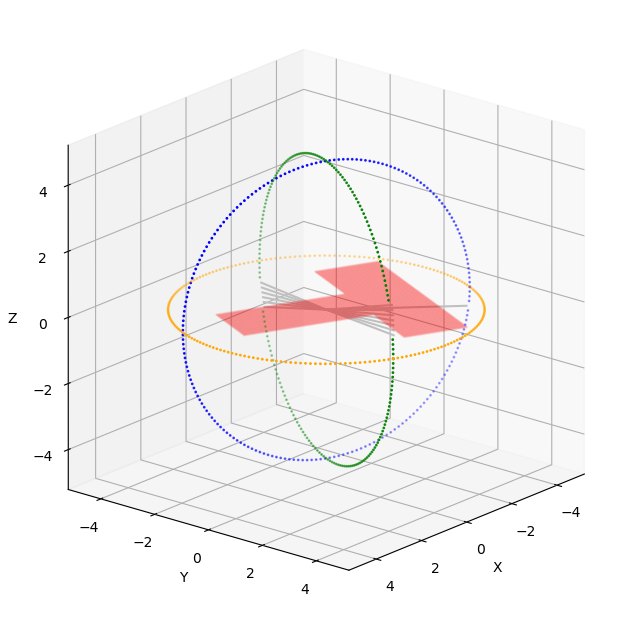

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

def compute_angle(A, B):
    """
    Compute the angles between vectors A and B.
    
    Parameters:
    - A: A 2D array where each row is a vector from the T-shape.
    - B: A 2D array where each row is a vector from a reference circle.
    
    Returns:
    - angles: A 2D array where each element (i, j) is the angle between vector A[i] and vector B[j].
    """
    dot_product = np.einsum('ij,kj->ik', A, B)
    mod_A = np.linalg.norm(A, axis=1)[:, np.newaxis]
    mod_B = np.linalg.norm(B, axis=1)
    
    cos_theta = dot_product / (mod_A * mod_B)
    cos_theta = np.clip(cos_theta, -1, 1) # Clip values to handle potential numerical errors
    angles = np.arccos(cos_theta)
    
    return angles

class TShapePlotter:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')

    azim = 30
    elev = 20
    f = 1

    def __init__(self, top_len, stem_len, w):
        self.top_len = top_len
        self.stem_len = stem_len
        self.w = w

    def _generate_t(self):
        # Calculate square and corner sizes
        self.frame_w = self.stem_len
        self.frame_h = self.top_len + self.w
        
        x, y = np.meshgrid(np.linspace(-self.frame_w/2, self.frame_w/2, 100), 
                           np.linspace(-self.frame_h/2, self.frame_h/2, 100))
        
        # Masks for removing bottom corners
        mask_left = np.logical_or(x > -self.w/2, y > self.frame_h/2 - self.w)
        mask_right = np.logical_or(x < self.w/2, y > self.frame_h/2 - self.w)
        mask = np.logical_and(mask_left, mask_right)
        
        self.t_shape = np.column_stack([x[mask], y[mask], np.zeros_like(x[mask])])

    def _generate_ref_circ(self, diameter, n_ref_points):
        theta = np.linspace(0, 2*np.pi, n_ref_points)

        # Circle parallel to XY plane
        x_xy = diameter/2 * np.cos(theta)
        y_xy = diameter/2 * np.sin(theta)
        z_xy = np.zeros_like(theta)
        
        # Circle parallel to YZ plane
        x_yz = np.zeros_like(theta)
        y_yz = diameter/2 * np.cos(theta)
        z_yz = diameter/2 * np.sin(theta)
        
        # Circle parallel to ZX plane
        x_zx = diameter/2 * np.cos(theta)
        y_zx = np.zeros_like(theta)
        z_zx = diameter/2 * np.sin(theta)

        self.xy_circle = np.column_stack([x_xy, y_xy, z_xy])
        self.yz_circle = np.column_stack([x_yz, y_yz, z_yz])
        self.zx_circle = np.column_stack([x_zx, y_zx, z_zx])

    def _rotate(self, coords, euler_angles):
        rotation = R.from_euler('ZYX', euler_angles, degrees=True)
        return rotation.apply(coords)

    def _ray_plane_intersection(self, ray_origin, ray_dir, plane_point, plane_normal):
        denom = np.dot(plane_normal, ray_dir)
        if abs(denom) < 1e-12: # ray is parallel to the plane
            return None
        t = np.dot(plane_point - ray_origin, plane_normal) / denom
        return ray_origin + t * ray_dir

    def _is_point_occluded(self, point):
        ray_dir = (point - self._camera_coords).astype(float)
        # test_array = np.column_stack((ray_dir, self._camera_coords))
        # self.ax.plot(test_array[0], test_array[1], test_array[2])

        ray_dir /= np.linalg.norm(ray_dir)

        # Define the planes of the T-shape
        plane_point = np.array([0, 0, 0])
        plane_normal = np.array([0, 0, 1])

        # Check intersections with the t-shape plane
        intersection = self._ray_plane_intersection(self._camera_coords, ray_dir, plane_point, plane_normal)

        isInFrame = np.abs(intersection[0]) <= self.frame_w/2 and np.abs(intersection[1]) <= self.frame_h/2
        isInLeftCorner = intersection[0] < -self.w/2 and intersection[1] < self.frame_h/2 - self.w
        isInRightCorner = intersection[0] > self.w/2 and intersection[1] < self.frame_h/2 - self.w

        if not isInFrame:
            return False
        elif isInLeftCorner or isInRightCorner:
            return False

        self.ax.plot([intersection[0], self._camera_coords[0]],
                                 [intersection[1], self._camera_coords[1]],
                                 [intersection[2], self._camera_coords[2]],
                                 c='silver')
        return True

        # if intersection is not None:
        #     # Check if the intersection point is within the frame boundaries
        #     if (abs(intersection[0]) <= self.stem_len/2 and abs(intersection[1]) <= self.frame_h/2) or \
        #        (abs(intersection[0]) <= self.frame_w/2 and abs(intersection[1]) <= self.top_len/2):
        #             # Check if the intersection point is not within the corners
        #             self.ax.plot([intersection[0], self._camera_coords[0]],
        #                          [intersection[1], self._camera_coords[1]],
        #                          [intersection[2], self._camera_coords[2]],
        #                          c='silver')
        #             return True  # Point is occluded
        return False
    
    def _mask_occlusion_ray_tracing(self, circle_vectors):
        mask = np.array([not self._is_point_occluded(point) for point in circle_vectors])
        # print(mask)
        return mask

    def draw(self, euler_angles=[0, 0, 0], ref_diameter=1.5, n_ref_points=200):
        self._generate_t()
        self._generate_ref_circ(ref_diameter*max(self.frame_h, self.frame_w),
                                   n_ref_points)
        
        t_rot = self._rotate(self.t_shape, euler_angles)
        xy_rot = self._rotate(self.xy_circle, euler_angles)
        yz_rot = self._rotate(self.yz_circle, euler_angles)
        zx_rot = self._rotate(self.zx_circle, euler_angles)

        # Plot the T-shape in 3D
        self.ax.view_init(elev=self.elev, azim=self.azim)
        self.ax.set_proj_type('persp', focal_length=self.f)
        self._camera_coords = (self.ax._dist + self.f) * np.array([
            np.cos(np.deg2rad(self.elev)) * np.cos(np.deg2rad(self.azim)),
            np.cos(np.deg2rad(self.elev)) * np.sin(np.deg2rad(self.azim)),
            np.sin(np.deg2rad(self.elev))
        ])

        # Compute masks for each reference circle
        mask_xy = self._mask_occlusion_ray_tracing(xy_rot)
        mask_yz = self._mask_occlusion_ray_tracing(yz_rot)
        mask_zx = self._mask_occlusion_ray_tracing(zx_rot)

        self.ax.scatter(t_rot[:, 0], t_rot[:, 1], t_rot[:, 2],
                        c='r', s=1, alpha=0.1)
        # Use masks to plot only the visible points on the reference circles
        self.ax.scatter(xy_rot[mask_xy][:, 0], xy_rot[mask_xy][:, 1], xy_rot[mask_xy][:, 2],
                        c='orange', s=1, label='XY Circle')
        self.ax.scatter(yz_rot[mask_yz][:, 0], yz_rot[mask_yz][:, 1], yz_rot[mask_yz][:, 2],
                        c='blue', s=1, label='YZ Circle')
        self.ax.scatter(zx_rot[mask_zx][:, 0], zx_rot[mask_zx][:, 1], zx_rot[mask_zx][:, 2],
                        c='green', s=1, label='ZX Circle')
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')

        self.ax.set_xlim([-5, 5])
        self.ax.set_ylim([-5, 5])
        self.ax.set_zlim([-5, 5])

        self.ax.set_box_aspect((1, 1, 1))
        plt.show()


plotter = TShapePlotter(4, 6, 2)
plotter.azim = 40
plotter.elev = 20
plotter.f = 100

plotter.draw([65, 0, 0], n_ref_points=200)

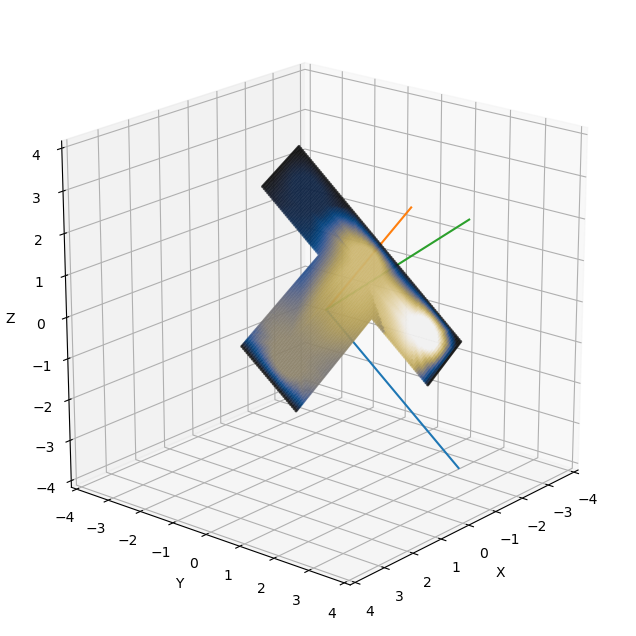

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import griddata
from cmap import Colormap

class TShapePlotter:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    azim = 30
    elev = 20

    def __init__(self, top_len, stem_len, w, diameter=5, centers=None):
        self.top_len = top_len
        self.stem_len = stem_len
        self.w = w
        self.diameter = diameter

        if centers is None:
            self.centers = [[15, 50], [85, 50], [85, 15], [85, 85]]
        else:
            self.centers = centers

        self.vals = np.zeros([100, 100])

    def _generate_t(self):
        # Calculate square and corner sizes
        self.frame_w = self.stem_len
        self.frame_h = self.top_len + self.w
        
        x, y = np.meshgrid(np.linspace(-self.frame_w/2, self.frame_w/2, 100), 
                           np.linspace(-self.frame_h/2, self.frame_h/2, 100))
        
        # Masks for removing bottom corners
        mask_left = np.logical_or(x > -self.w/2, y > self.frame_h/2 - self.w)
        mask_right = np.logical_or(x < self.w/2, y > self.frame_h/2 - self.w)
        mask = np.logical_and(mask_left, mask_right)
        self.t_shape = np.column_stack([x[mask], y[mask], np.zeros_like(x[mask])])

        self._t_mask = mask

    def _generate_ref_vec(self, d):
        self.x_vec = np.array([d, 0, 0])
        self.y_vec = np.array([0, d, 0])
        self.z_vec = np.array([0, 0, d])

    def _generate_vals(self):
        self.vals = self.vals[self._t_mask]

    def _rotate(self, coords, euler_angles):
        rotation = R.from_euler('ZYX', euler_angles, degrees=True)
        return rotation.apply(coords)

    def _interpolate(self):
        known_points = np.column_stack(np.where(np.logical_or(self.vals != 0,
                                                              np.isin(np.arange(100), [0, 99])[:, None] |
                                                              np.isin(np.arange(100), [0, 99])[None, :])))
        known_values = self.vals[known_points[:, 0], known_points[:, 1]]

        # Generate grid for the entire array
        grid_x, grid_y = np.mgrid[0:99:100j, 0:99:100j]

        # Interpolate values for the entire grid
        self.vals = griddata(known_points, known_values, (grid_x, grid_y),
                             method='cubic', fill_value=0)
        
    def update_pv(self, values):
        for i, center in enumerate(self.centers):
            y, x = np.ogrid[-center[0]:100-center[0], -center[1]:100-center[1]]
            mask = x*x + y*y <= (self.diameter/2)**2
            self.vals[mask] = values[i]
        self._interpolate()


    def draw(self, euler_angles=[0, 0, 0], ref_diameter=0.8):
        self._generate_t()
        self._generate_ref_vec(ref_diameter*max(self.frame_h, self.frame_w))
        self._generate_vals()
        
        self.t_rot = self._rotate(self.t_shape, euler_angles)
        self.x_rot = self._rotate(self.x_vec, euler_angles)
        self.y_rot = self._rotate(self.y_vec, euler_angles)
        self.z_rot = self._rotate(self.z_vec, euler_angles)

        # Plot the T-shape in 3D
        self.ax.view_init(elev=self.elev, azim=self.azim)
        self.ax.set_proj_type('persp')

        self.ax.scatter(self.t_rot[:, 0], self.t_rot[:, 1], self.t_rot[:, 2],
                        c=self.vals, s=2,
                        cmap=Colormap('colorcet:CET_CBL1').to_matplotlib(),
                        alpha=0.7)
        self.ax.plot([self.x_rot[0], 0], [self.x_rot[1], 0], [self.x_rot[2], 0])
        self.ax.plot([self.y_rot[0], 0], [self.y_rot[1], 0], [self.y_rot[2], 0])
        self.ax.plot([self.z_rot[0], 0], [self.z_rot[1], 0], [self.z_rot[2], 0])
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        self.ax.set_zlabel('Z')

        self.ax.set_xlim([-4, 4])
        self.ax.set_ylim([-4, 4])
        self.ax.set_zlim([-4, 4])

        self.ax.set_box_aspect((1, 1, 1))
        plt.show()


plotter = TShapePlotter(4, 6, 2, diameter=15)
plotter.azim = 40
plotter.elev = 20

plotter.update_pv([0.5, 0.7, 0.1, 0.9])  # Example sensor values
plotter.draw([120, 50, 20])

(5050, 3)


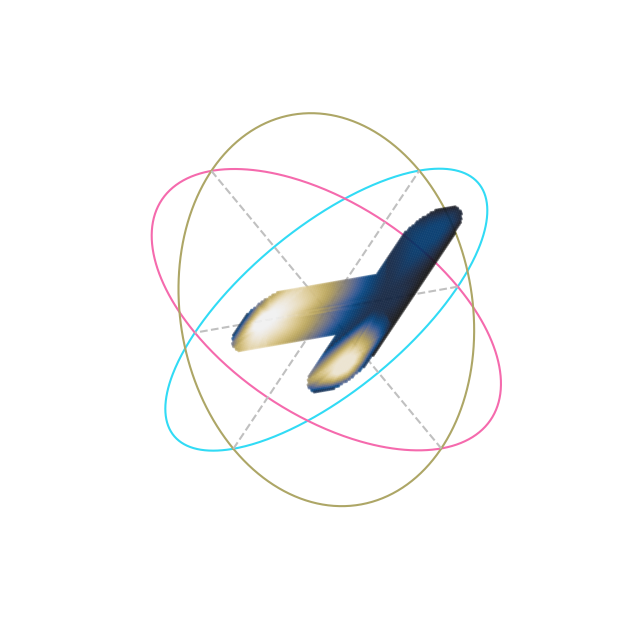

: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import griddata
from cmap import Colormap

class TShapePlotter:
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    azim = 30
    elev = 20

    def __init__(self, top_len, stem_len, w, pd_dia=5, centers=None, rc=0):
        self.top_len = top_len
        self.stem_len = stem_len
        self.w = w
        self.pd_dia = pd_dia
        self.rc = rc

        if centers is None:
            self.centers = [[15, 50], [85, 50], [85, 15], [85, 85]]
        else:
            self.centers = centers

        self.vals = np.zeros([100, 100])

    def _generate_t(self):
        # Calculate square and corner sizes
        self.frame_w = self.stem_len
        self.frame_h = self.top_len + self.w
        
        x, y = np.meshgrid(np.linspace(-self.frame_w/2, self.frame_w/2, 100), 
                           np.linspace(-self.frame_h/2, self.frame_h/2, 100))
        
        # Masks for removing bottom corners
        mask_left = np.logical_or(x > -self.w/2, y > self.frame_h/2 - self.w)
        mask_right = np.logical_or(x < self.w/2, y > self.frame_h/2 - self.w)
        mask = np.logical_and(mask_left, mask_right)

        # Masks for removing corners
        if self.rc > 0:
            exclude_masks = [
                np.logical_and(x <= -self.frame_w/2 + self.rc, y >= self.frame_h/2 - self.rc), # ttl
                np.logical_and(x >= self.frame_w/2 - self.rc, y >= self.frame_h/2 - self.rc), # ttr
                np.logical_and(x <= -self.frame_w/2 + self.rc, y <= self.frame_h/2 - self.w + self.rc), # tbl
                np.logical_and(x >= self.frame_w/2 - self.rc, y <= self.frame_h/2 - self.w + self.rc), # tbr
                np.logical_and(x <= -self.w/2 + self.rc, y <= -self.frame_h/2 + self.rc), # vbl
                np.logical_and(x >= self.w/2 - self.rc, y <= -self.frame_h/2 + self.rc) # vbr
            ]

            exclude_combined_mask = np.any(exclude_masks, axis=0)
            mask = np.logical_and(mask, np.logical_not(exclude_combined_mask))

            include_masks = [
                np.sqrt((x - (-self.frame_w/2 + self.rc))**2 + (y - (self.frame_h/2 - self.rc))**2) <= self.rc, # ttl
                np.sqrt((x - (self.frame_w/2 - self.rc))**2 + (y - (self.frame_h/2 - self.rc))**2) <= self.rc, # ttr
                np.sqrt((x - (-self.frame_w/2 + self.rc))**2 + (y - (self.frame_h/2 - self.w + self.rc))**2) <= self.rc, # tbl
                np.sqrt((x - (self.frame_w/2 - self.rc))**2 + (y - (self.frame_h/2 - self.w + self.rc))**2) <= self.rc, # tbr
                np.sqrt((x - (-self.w/2 + self.rc))**2 + (y - (-self.frame_h/2 + self.rc))**2) <= self.rc, # vbl
                np.sqrt((x - (self.w/2 - self.rc))**2 + (y - (-self.frame_h/2 + self.rc))**2) <= self.rc # vbr
            ]
            
            include_combined_mask = np.any(include_masks, axis=0)
            mask = np.logical_or(mask, include_combined_mask)

        self.t_shape = np.column_stack([x[mask], y[mask], np.zeros_like(x[mask])])
        print(self.t_shape.shape)
        self._t_mask = mask

    def _generate_ref_circ(self, diameter, n_ref_points):
        theta = np.linspace(0, 2*np.pi, n_ref_points)

        # Circle parallel to XY plane
        x_xy = diameter/2 * np.cos(theta)
        y_xy = diameter/2 * np.sin(theta)
        z_xy = np.zeros_like(theta)
        
        # Circle parallel to YZ plane
        x_yz = np.zeros_like(theta)
        y_yz = diameter/2 * np.cos(theta)
        z_yz = diameter/2 * np.sin(theta)
        
        # Circle parallel to ZX plane
        x_zx = diameter/2 * np.cos(theta)
        y_zx = np.zeros_like(theta)
        z_zx = diameter/2 * np.sin(theta)

        self.xy_circle = np.column_stack([x_xy, y_xy, z_xy])
        self.yz_circle = np.column_stack([x_yz, y_yz, z_yz])
        self.zx_circle = np.column_stack([x_zx, y_zx, z_zx])

    def _generate_axes(self, diameter):
        self.intersect_y = np.array([[0, diameter / 2, 0], [0, -diameter / 2, 0]])
        self.intersect_z = np.array([[0, 0, diameter / 2], [0, 0, -diameter / 2]])
        self.intersect_x = np.array([[diameter / 2, 0, 0], [-diameter / 2, 0, 0]])

    def _generate_vals(self):
        self.vals = self.vals[self._t_mask]

    def _rotate(self, coords, euler_angles):
        rotation = R.from_euler('ZYX', euler_angles, degrees=True)
        return rotation.apply(coords)

    def _interpolate(self):
        known_points = np.column_stack(np.where(np.logical_or(self.vals != 0,
                                                              np.isin(np.arange(100), [0, 99])[:, None] |
                                                              np.isin(np.arange(100), [0, 99])[None, :])))
        known_values = self.vals[known_points[:, 0], known_points[:, 1]]

        # Generate grid for the entire array
        grid_x, grid_y = np.mgrid[0:99:100j, 0:99:100j]

        # Interpolate values for the entire grid
        self.vals = griddata(known_points, known_values, (grid_x, grid_y),
                             method='cubic', fill_value=0)
        
    def update_pv(self, values):
        for i, center in enumerate(self.centers):
            y, x = np.ogrid[-center[0]:100-center[0], -center[1]:100-center[1]]
            mask = x*x + y*y <= (self.pd_dia/2)**2
            self.vals[mask] = values[i]
        self._interpolate()


    def draw(self, euler_angles=[0, 0, 0], ref_diameter=1.5, n_ref_points=500):
        self._generate_t()
        self._generate_ref_circ(ref_diameter*max(self.frame_h, self.frame_w), n_ref_points)
        self._generate_axes(ref_diameter*max(self.frame_h, self.frame_w))
        self._generate_vals()
        
        self.t_rot = self._rotate(self.t_shape, euler_angles)
        self.xy_rot = self._rotate(self.xy_circle, euler_angles)
        self.yz_rot = self._rotate(self.yz_circle, euler_angles)
        self.zx_rot = self._rotate(self.zx_circle, euler_angles)
        self.intersect_y_rot = self._rotate(self.intersect_y, euler_angles)
        self.intersect_z_rot = self._rotate(self.intersect_z, euler_angles)
        self.intersect_x_rot = self._rotate(self.intersect_x, euler_angles)

        # Plot the T-shape in 3D
        self.ax.view_init(elev=self.elev, azim=self.azim)
        self.ax.set_proj_type('ortho')

        self.ax.scatter(self.t_rot[:, 0], self.t_rot[:, 1], self.t_rot[:, 2],
                        c=self.vals, s=2,
                        cmap=Colormap('colorcet:CET_CBL1').to_matplotlib(),
                        vmax=1, vmin=0,
                        alpha=0.5)
        
        # Plot the circles
        self.ax.plot(self.xy_rot[:, 0], self.xy_rot[:, 1], self.xy_rot[:, 2],
                     c='#31DBF5', label='XY Circle', alpha=1)
        self.ax.plot(self.yz_rot[:, 0], self.yz_rot[:, 1], self.yz_rot[:, 2],
                     c='#F56AAD', label='XY Circle', alpha=1)
        self.ax.plot(self.zx_rot[:, 0], self.zx_rot[:, 1], self.zx_rot[:, 2],
                     c='#ADA666', label='XY Circle', alpha=1)
        
        # Plot the axes
        self.ax.plot(self.intersect_y_rot[:, 0], self.intersect_y_rot[:, 1], self.intersect_y_rot[:, 2],
                     c='silver', ls='--')
        self.ax.plot(self.intersect_z_rot[:, 0], self.intersect_z_rot[:, 1], self.intersect_z_rot[:, 2],
                     c='silver', ls='--')
        self.ax.plot(self.intersect_x_rot[:, 0], self.intersect_x_rot[:, 1], self.intersect_x_rot[:, 2],
                     c='silver', ls='--')

        self.ax.set_xlim([-4, 4])
        self.ax.set_ylim([-4, 4])
        self.ax.set_zlim([-4, 4])

        self.ax.set_box_aspect((1, 1, 1))
        self.ax.grid(False)

        plt.axis('off')

        plt.show()


plotter = TShapePlotter(4, 6, 2, pd_dia=10, rc=1)
plotter.azim = 40
plotter.elev = 30

plotter.update_pv([1.0, 0.1, 0.2, 0.95])  # Example sensor values
plotter.draw([10, 20, 30])

In [2]:
import numpy as np

arr = np.array([[5, 5, 5], [10, 10, 10]])
mask = np.array([[False, False, True], [True, True, False]])
arr[mask]

array([ 5, 10, 10])